

# Honors project


# Introduction

We will be working with a data set based on housing prices derived from the U.S. Census Service 
There are an extensive number of features, so they've been described in the table below.
### Features
·      CRIM - per capita crime rate by town

·      ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

·      INDUS - proportion of non-retail business acres per town.

·      CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

·      NOX - nitric oxides concentration (parts per 10 million)

·      RM - average number of rooms per dwelling

·      AGE - proportion of owner-occupied units built prior to 1940

·      DIS - weighted distances to five Boston employment centres

·      RAD - index of accessibility to radial highways

·      TAX - full-value property-tax rate per $10,000

·      PTRATIO - pupil-teacher ratio by town

·      LSTAT - % lower status of the population

·      MEDV - Median value of owner-occupied homes in $1000's

### Objectives

Is there a significant difference in median value of houses bounded by the Charles river or not? (T-test for independent samples)

Is there a difference in Median values of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE)? (ANOVA)

Can we conclude that there is no relationship between Nitric oxide concentrations and proportion of non-retail business acres per town? (Pearson Correlation)

What is the impact of an additional weighted distance  to the five Boston employment centres on the median value of owner occupied homes? (Regression analysis)

In [106]:
#Surpress warnings
import warnings 
warnings.filterwarnings('ignore')

In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.pyplot as pyplot
import scipy.stats as stats 
from scipy.stats import chi2_contingency

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 
import statsmodels.api as sm

In [108]:
boston_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv'
boston_df=pd.read_csv(boston_url)

In [109]:
boston_df.head()

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [110]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    float64
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    float64
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  LSTAT       506 non-null    float64
 13  MEDV        506 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 55.5 KB


In [111]:
boston_df.shape

(506, 14)

# Is there a significant difference in median value of houses bounded by the Charles river or not?

First, lets visualize the relationship between CHAS and MEDV data.

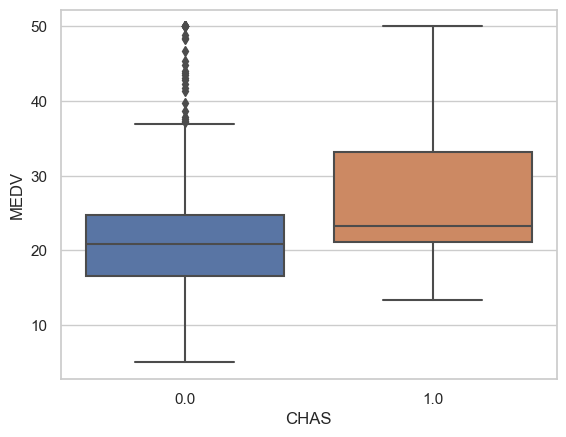

In [112]:
ax = sns.boxplot(x='CHAS', y="MEDV", data=boston_df)

From the graph above, the boxplot of the median value of houses bound by Charles river have higher interquatile range than the boxplot of the median value of houses not bound by Charles river. Also, median value of houses not bound by Charles river above 37 are outliers.

In [113]:
# Find the average MEDV in both groups of river bound and otherwise charles river variable
division_eval = boston_df.groupby('CHAS')[['MEDV']].mean().reset_index()

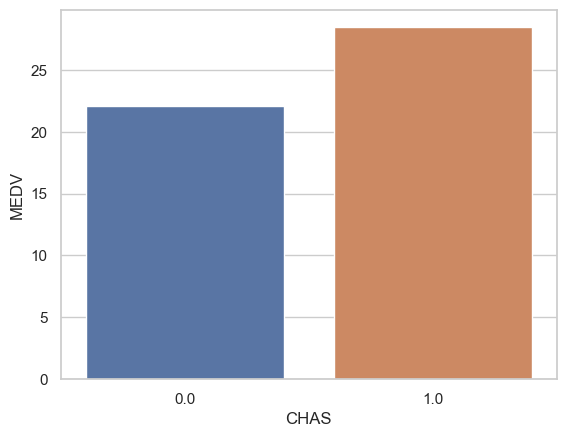

In [114]:
# Bar plot using the Seaborn library
sns.set(style="whitegrid")
ax = sns.barplot(x="CHAS", y="MEDV", data=division_eval)

From the graph above, the average median value of houses bound by Charles river is higher than the average median value of houses not bound by Charles river

Next, state the hypothesis:
* $H_0: µ_1 = µ_2$ ("there's no significant difference in median value of houses bound by Charles river")
* $H_1: µ_1 ≠ µ_2$ ("there is a significant difference in median value of houses bound by Charles river")

Confidence level is 5%.

Next, use the <code>ttest_ind</code> from the <code>scipy_stats</code> library

In [115]:
scipy.stats.ttest_ind(boston_df[boston_df['CHAS'] == 1.0]['MEDV'],
                   boston_df[boston_df['CHAS'] == 0.0]['MEDV'], equal_var = True)

Ttest_indResult(statistic=3.996437466090509, pvalue=7.390623170519905e-05)

Conclusion: Since the p-value is less than 0.05, we will reject the null hypothesis as there is a significant difference in median value of houses bound by Charles river

# Is there a difference in Median values of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE)?

First, we group the data into categories as the one-way ANOVA can't work with continuous variable, we will create a new column for this newly assigned group our categories will be owners that are:
* 35 years and younger
* between 35 and 70 years
* 70 years and older


In [116]:
boston_df.loc[(boston_df['AGE'] <= 35), 'age_group'] = '35 years and younger'
boston_df.loc[(boston_df['AGE'] > 35)&(boston_df['AGE'] < 70), 'age_group'] = 'between 35 and 70 years'
boston_df.loc[(boston_df['AGE'] >= 70), 'age_group'] = '70 years and older'

visualizing the grouped data

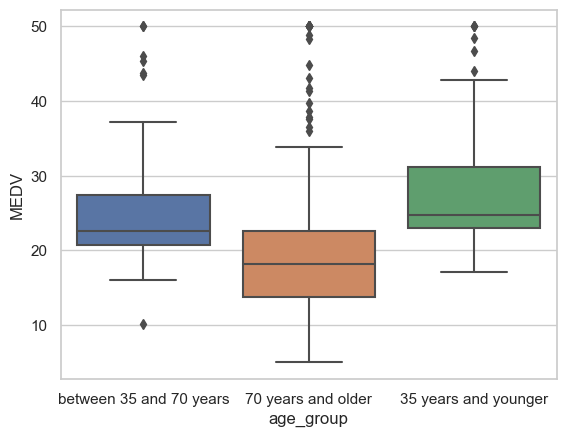

In [117]:
ax = sns.boxplot(x='age_group', y="MEDV", data=boston_df)

The upper and lower whisker of 35 years and younger age group is greater than the upper and lower whisker between 35 and 70 years. The upper and lower whisker between 35 and 70 years is greater than the upper and lower whisker of 70 years and older age group. All groups have outliers.

Next, state the hypothesis:
* $H_0: µ_1 = µ_2$ ("there's no significant difference in median value of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE)")
* $H_1: µ_1 ≠ µ_2$ ("there is a significant difference in median value of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE)")

Confidence level is 5%.

Next, separate the three samples (one for each job category) into a variable each.

In [118]:
b=boston_df[boston_df['age_group'] == '35 years and younger']['MEDV']
c=boston_df[boston_df['age_group'] == 'between 35 and 70 years']['MEDV']
d=boston_df[boston_df['age_group'] == '70 years and older']['MEDV']

Next, run a one-way ANOVA.

In [119]:
f_statistic, p_value = scipy.stats.f_oneway(b, c, d)
print("F_Statistic: {0}, P-Value: {1}".format(f_statistic,p_value))

F_Statistic: 36.40764999196599, P-Value: 1.7105011022702984e-15


Conclusion: Since the p-value is less than 0.05, we will reject the null hypothesis as there is a significant difference in median value of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE).

# Can we conclude that there is no relationship between Nitric oxide concentrations and proportion of non-retail business acres per town?

First let visualize the relationship betweem Nitric oxide concentrations(NOX) and proportion of non-retail business acres per town(INDUS)?

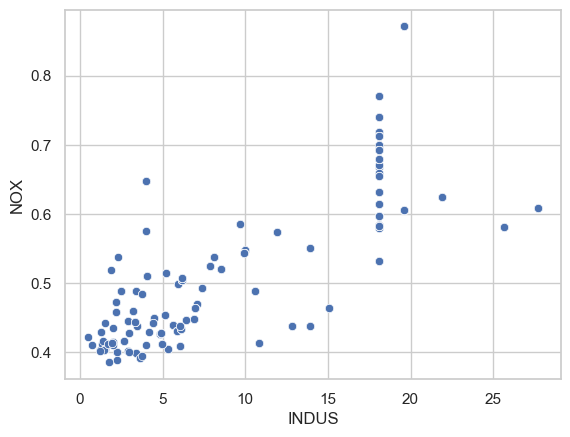

In [120]:
# Create scatterplot with the scatterplot function in the seaborn library
ax = sns.scatterplot(x='INDUS', y='NOX',
                     data=boston_df)

From the graph above, there's a direct proportionality between nitric oxide concentration (NOX) and proportion of non-retail business acres per town.

Next state the hypothesis:
* $H_0:$ Nitric oxide concentration is not correlated with proportion of non-retail business acres per town
* $H_1:$ Nitric oxide concentration is correlated with proportion of non-retail business acres per town

Confidence level is 5%

Since they are both continuous variables we can use a pearson correlation test

In [121]:
scipy.stats.pearsonr(boston_df['NOX'], boston_df['INDUS'])

PearsonRResult(statistic=0.7636514469209151, pvalue=7.913361061238693e-98)

**Conclusion:** Since the p-value  (Sig. (2-tailed)  < 0.05, we reject  the Null hypothesis and conclude that there  exists a relationship between  Nitric oxide concentration and proportion of non-retail business acres per town.

#### Create a histogram for the pupil to teacher ratio variable

[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

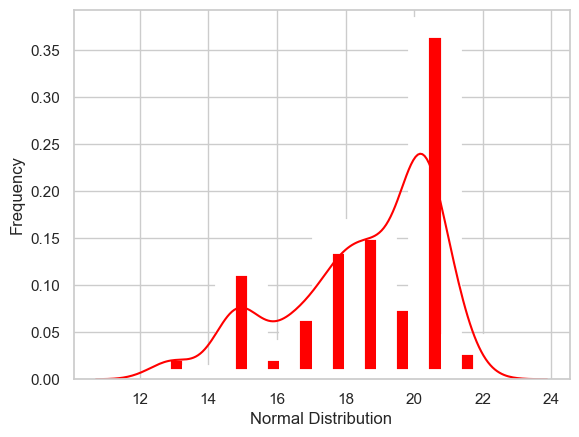

In [122]:
ax = sns.distplot(boston_df['PTRATIO'],
                  bins=10,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')
## we can assume it is normal

From the graph above, the normal distribution curve is skewed to the left.

# What is the impact of an additional weighted distance  to the five Boston employment centres on the median value of owner occupied homes?

First, create a scatterplot with the scatterplot function in the seaborn library


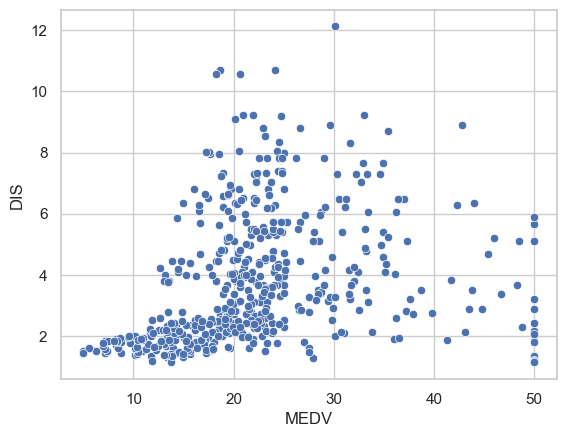

In [123]:
ax = sns.scatterplot(x='MEDV', y='DIS',
                     data=boston_df)

The graph above shows positive correlation between DIS and MEDV

Next state the hypothesis:
* $H_0:$ Additional weighted distance to the five Boston employment centres is not correlated with median value of owner occupied homes
* $H_1:$ Additional weighted distance to the five Boston employment centres is correlated with median value of owner occupied homes

Confidence level is 5%

In [124]:
## X is the input variables (or independent variables)
X = boston_df['DIS']
## y is the target/dependent variable
y = boston_df['MEDV']
## add an intercept (beta_0) to our model
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.58
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           1.21e-08
Time:                        06:11:07   Log-Likelihood:                -1823.9
No. Observations:                 506   AIC:                             3652.
Df Residuals:                     504   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3901      0.817     22.499      0.000      16.784      19.996
DIS            1.0916      0.188      5.795      0.000       0.722       1.462
==============================================================================
Omnibus:                      139.779   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.104
Skew:                           1.466   Prob(JB):                     5.59e-67
Kurtosis:                       5.424   Cond. No.                         9.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since p < 0.05 we reject the null hypothesis as there is evidence of correlation between DIS and MEDV

Conclusion: An additional weighted distance to the five Boston employment centres is most likely going to increase  median value of owner occupied homes.

## References

IBM Skills Build

## Author

Adedoyinsola Ogungbesan